<a href="https://colab.research.google.com/github/niccolofusai13/Food-Demand-Forecasting/blob/main/Food_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### This notebook represents a solution to the Kaggle Competition 'Food Demand Forecasting' 
Link: https://www.kaggle.com/kannanaikkal/food-demand-forecasting


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change this to the path to data folder in your own drive
data_path = '/content/drive/MyDrive/AML/Data_Demand_Forecasting'

## Imports

# EDA

In [4]:
pip install category_encoders

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

## Data Loading 

In [6]:
train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_path, 'test.csv'))
meal_info = pd.read_csv(os.path.join(data_path, 'meal_info.csv'))
center_info = pd.read_csv(os.path.join(data_path, 'fulfilment_center_info.csv'))


In [7]:
train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [8]:
test_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [9]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [10]:
center_info.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [12]:
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [13]:
center_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


**Exciting, there is no obvious missing data**

In [14]:
# pre-process
train_data = pd.merge(train_data,meal_info,on='meal_id',how='left')
train_data = pd.merge(train_data,center_info, on='center_id', how='left')
# note that test data doesn't have label
test_data = pd.merge(test_data, meal_info, on='meal_id', how='left')
test_data = pd.merge(test_data, center_info, on='center_id', how='left')

In [15]:
train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


In [16]:
test_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1127204,146,55,1993,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1212707,146,55,2539,157.14,159.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1082698,146,55,2631,162.02,162.02,0,0,Beverages,Indian,647,56,TYPE_C,2.0
4,1400926,146,55,1248,163.93,163.93,0,0,Beverages,Indian,647,56,TYPE_C,2.0


## Data Exploration

### Category, Cuisine and City Code 

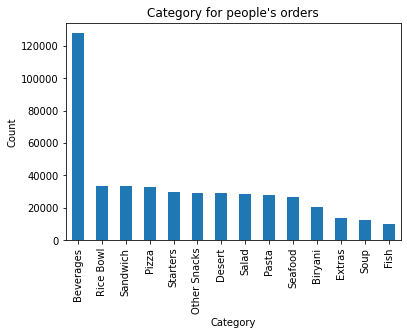

In [17]:
train_data['category'].value_counts().plot(kind='bar')
plt.title("Category for people's orders")
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

It's obvious that the Beverage is the most popular product for people and fish is the least. Also, they think 
rice bowl, sandwich, and pizza which are main courses have the same value through their life. Hence, we can provide
more beverages and less fish.

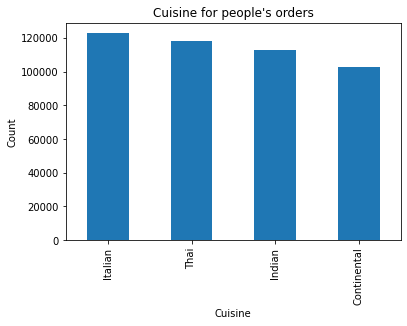

In [18]:
train_data['cuisine'].value_counts().plot(kind='bar')
plt.title("Cuisine for people's orders")
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.show()

We can observe that Italian is the most popular style for people to accept, then thai food is the second popular and Continental is the least. However, the intensity of the popular for those cuisine styles are not so much different from each other, which we can conclude the cuisine is globaly accpected for people.

In [19]:
city_vs_orders = train_data.groupby(by=['city_code']).sum().sort_values(by="num_orders", ascending=False)

In [20]:
city_vs_orders.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,region_code,op_area
city_code,,,,,,,,,,,
590,68500380033,4096327,4009581,109676519,1.809698e+07,1.932221e+07,3863,5462,19849062,3065776,243376.6
526,54460969019,3234304,3569828,88571571,1.454972e+07,1.543552e+07,3928,4126,9207953,1479850,164640.4
638,25075737939,1501585,1264329,40143244,6.610136e+06,7.074404e+06,1366,2518,6662450,1122632,120947.8
604,16311572669,973022,711660,26137348,4.279638e+06,4.606252e+06,904,1476,3533367,731472,55950.6
522,16860730917,1005792,1029436,27049640,4.454606e+06,4.759807e+06,910,1363,3375905,753704,53157.2


In [21]:
city_vs_orders.tail()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,region_code,op_area
city_code,,,,,,,,,,,
658,6981698535,418663,900151,11449377,1882743.50,2006411.62,542,612,813948,190094,21804.9
541,5616570486,334282,256557,9156923,1463309.87,1566797.27,481,379,768013,346577,12602.8
693,5774136160,345139,643153,9339460,1465443.75,1567617.08,489,484,743148,157318,12955.6
702,6589564742,390419,389536,10882981,1758719.84,1868701.41,518,438,691044,184240,14739.2
478,6278827384,372444,748129,10349169,1625222.55,1741617.52,498,437,637527,386617,12050.4


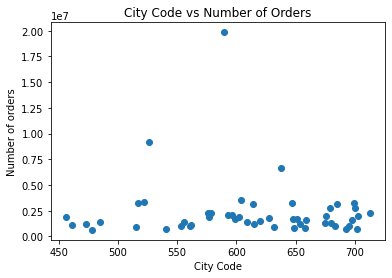

In [22]:
plt.scatter(city_vs_orders.index, city_vs_orders.num_orders)
plt.xlabel('City Code')
plt.ylabel('Number of orders')
plt.title('City Code vs Number of Orders')
plt.show()

We can infer from the result that 3 of the cities has the most orders while the rest of the cities are pretty much on average

### Features: Checkout_price, base_price and region code 

In [23]:
features = ['checkout_price','base_price','region_code']
target = train_data['num_orders']
print(f'missing values in checkout price: ', any(train_data['checkout_price'].isnull()))
print(f'missing values in base price: ', any(train_data['base_price'].isnull()))
print(f'missing values in region code: ', any(train_data['region_code'].isnull()))
print(f'missing values in number of orders: ', any(train_data['num_orders'].isnull()))

missing values in checkout price:  False
missing values in base price:  False
missing values in region code:  False
missing values in number of orders:  False


It seems there's no missing valuse in checkout price, base price and region code. Also no missing values in target. 

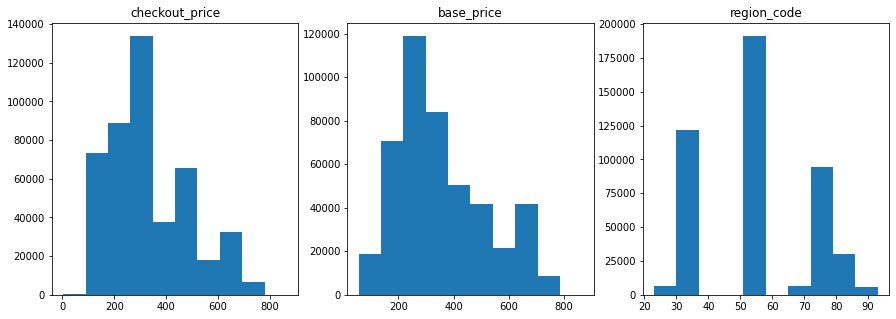

In [24]:
ind = 0
plt.figure(figsize=(15,5))
for i in features:
    ind+=1
    plt.subplot(1,3,ind)
    plt.hist(train_data[i])
    plt.title(i)

For check out and base price, the distributions are a bit skew to the right. For region code distribution, it looks like the data is gathered from several specific regions. 

In [25]:
print(train_data['region_code'].unique())

[56 85 77 34 35 71 93 23]


It's based on 8 regions.

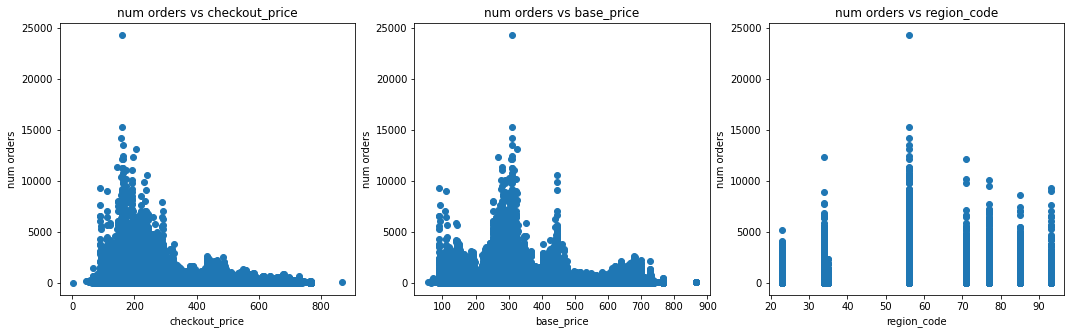

In [26]:
ind = 0
plt.figure(figsize=(18,5))
for i in features:
    ind+=1
    plt.subplot(1,3,ind)
    plt.scatter(train_data[i],target)
    plt.title(f'num orders vs '+i)
    plt.xlabel(i)
    plt.ylabel('num orders')

It doesn't look like there's relationship between check out price, base price, region code and our target. However, at some specific values of the three features, number of orders are higher than others.

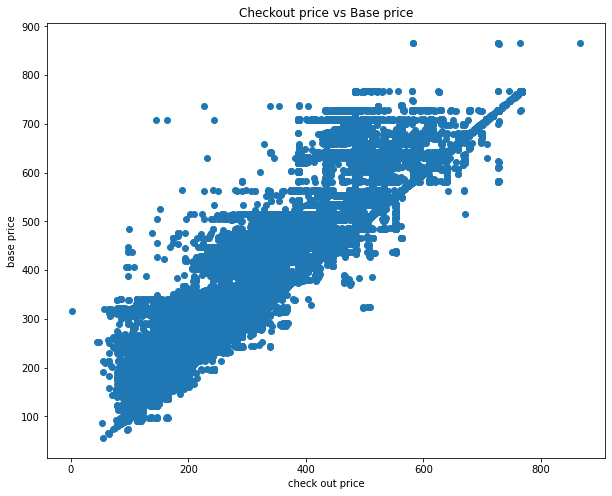

In [27]:
plt.figure(figsize=(10,8))
plt.scatter(train_data['checkout_price'],train_data['base_price'])
plt.xlabel('check out price')
plt.ylabel('base price')
plt.title('Checkout price vs Base price')
plt.show()

There's a linear relationship between check out price and base price (since they are related). 

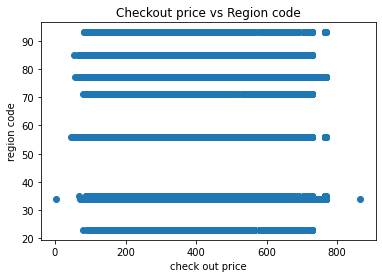

In [28]:
plt.scatter(train_data['checkout_price'],train_data['region_code'])
plt.xlabel('check out price')
plt.ylabel('region code')
plt.title('Checkout price vs Region code')
plt.show()

There's no relationship between check out price and region code, same for base price and region code.

### homepage_featured, emailer_for_promotion 

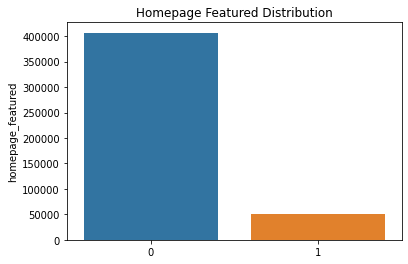

In [29]:
fig,ax = plt.subplots(1,1,figsize=(6,4));
sns.barplot(train_data['homepage_featured'].value_counts().index,train_data['homepage_featured'].value_counts());
    
ax.set_title("Homepage Featured Distribution");

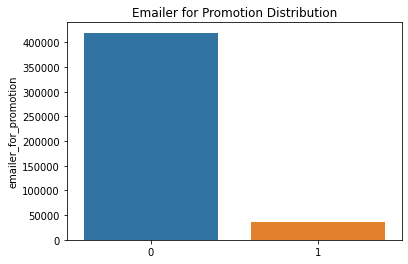

In [30]:
fig,ax = plt.subplots(1,1,figsize=(6,4));
sns.barplot(train_data['emailer_for_promotion'].value_counts().index,train_data['emailer_for_promotion'].value_counts());

ax.set_title("Emailer for Promotion Distribution");

In [31]:
train_data['emailer_for_promotion'].value_counts()

0    419498
1     37050
Name: emailer_for_promotion, dtype: int64

In [32]:
week_train = train_data.groupby(by='week').mean()
week_train.head()

,id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
week,,,,,,,,,,,
1,1.247659e+06,81.552019,1977.382957,330.530205,348.516537,0.122177,0.141684,271.136550,601.802190,56.670431,4.079877
2,1.248203e+06,81.420925,1980.309738,323.926944,347.299448,0.214434,0.177486,271.783149,601.921961,56.691298,4.085014
3,1.247274e+06,81.822008,1974.210072,327.202580,347.827544,0.035874,0.109003,239.828217,601.939289,56.703346,4.078682
4,1.250912e+06,81.723088,1980.793354,330.160502,348.372066,0.000000,0.101073,257.365524,601.919003,56.641398,4.087747
5,1.249198e+06,83.101434,1980.389647,315.194676,350.148709,0.117873,0.162994,419.263729,601.981462,56.298356,4.077824


In [33]:
center_id_train = train_data.groupby(by='center_id').mean()
center_id_train.head()

,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
center_id,,,,,,,,,,,
10,1.251659e+06,74.715324,2006.095510,335.615692,356.333507,0.065146,0.115467,481.969779,590.0,56.0,6.3
11,1.247223e+06,74.610793,2007.852228,329.763219,351.403858,0.066755,0.106014,411.307161,679.0,56.0,3.7
13,1.250429e+06,74.691314,2003.845160,334.935542,355.689303,0.064859,0.143060,609.784984,590.0,56.0,6.7
14,1.249176e+06,74.294819,1994.082271,323.117025,347.279429,0.072836,0.134084,197.832809,654.0,56.0,2.7
17,1.249501e+06,73.814464,1989.942523,327.628844,351.026956,0.070425,0.093479,192.376283,517.0,56.0,3.2


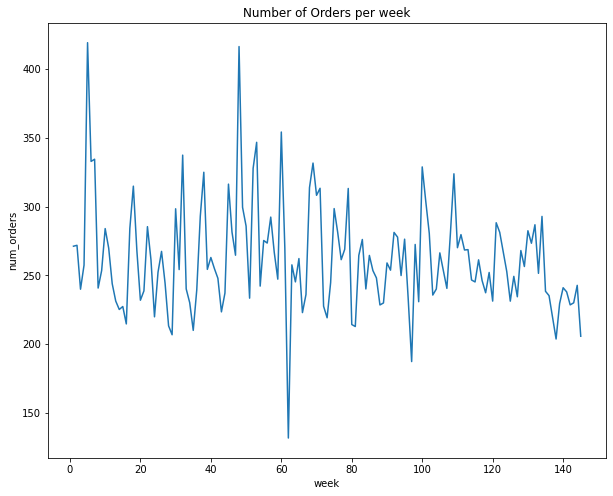

In [34]:
fig,ax = plt.subplots(1,1,figsize=(10,8));
sns.lineplot(data = week_train, x=week_train.index, y= 'num_orders');
ax.set_title("Number of Orders per week");

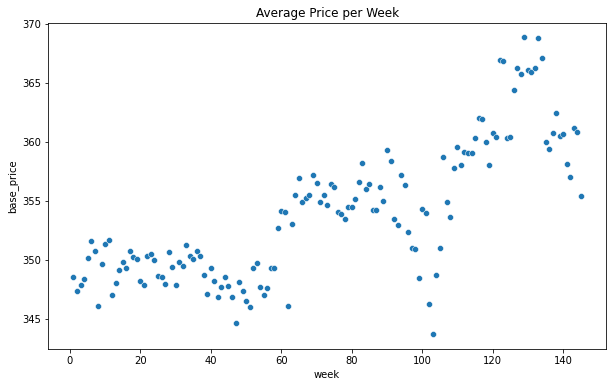

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,6));
sns.scatterplot(data = week_train, x= week_train.index, y= "base_price");
ax.set_title("Average Price per Week");

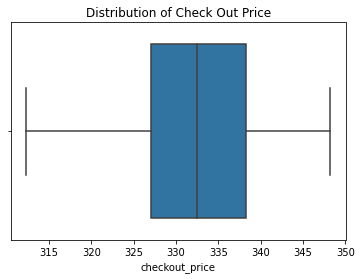

In [36]:
fig,ax = plt.subplots(1,1,figsize=(6,4));
sns.boxplot(data = week_train, x= "checkout_price");
ax.set_title("Distribution of Check Out Price");

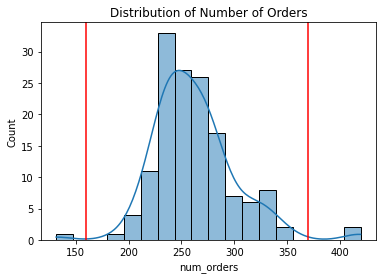

In [37]:
fig,ax = plt.subplots(1,1,figsize=(6,4));
sns.histplot(data = week_train, x= "num_orders", kde = True);
ax.set_title("Distribution of Number of Orders");
ax.axvline(160, color = 'red')
ax.axvline(370, color = 'red')

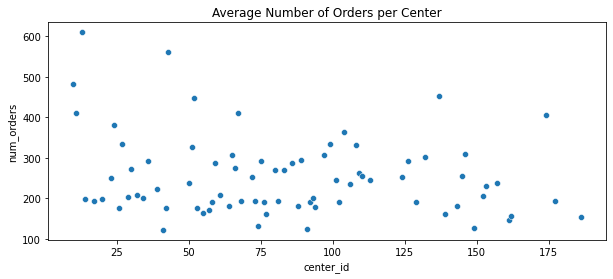

In [38]:
fig,ax = plt.subplots(1,1,figsize=(10,4));
sns.scatterplot(data = center_id_train, x= center_id_train.index, y= 'num_orders', ax=ax);
ax.set_title("Average Number of Orders per Center");

### features_1:'city_code','center_type','op_area'

In [39]:
features_1 = ['city_code','center_type','op_area']
print(f'missing values in city code: ', any(train_data['city_code'].isnull()))
print(f'missing values in center type: ', any(train_data['center_type'].isnull()))
print(f'missing values in op area: ', any(train_data['op_area'].isnull()))

missing values in city code:  False
missing values in center type:  False
missing values in op area:  False


no missing values

In [40]:
print(train_data['city_code'].unique())
print(train_data['center_type'].unique())

[647 614 679 659 526 590 599 685 461 649 541 478 703 576 628 702 579 596
 648 632 522 615 577 517 651 683 713 609 675 553 593 654 693 658 515 556
 561 680 620 638 700 676 604 456 562 695 699 602 485 698 473]
['TYPE_C' 'TYPE_B' 'TYPE_A']


There are 51 citys. and 3 center types

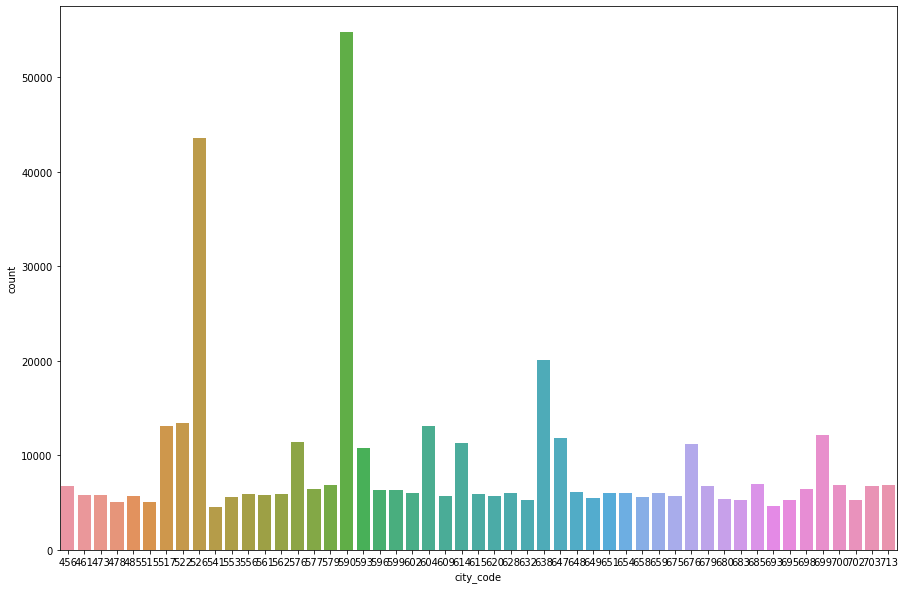

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x=train_data.city_code)

Most of the citys have around 5000-7000 data points, expect for a few, such as 252 959

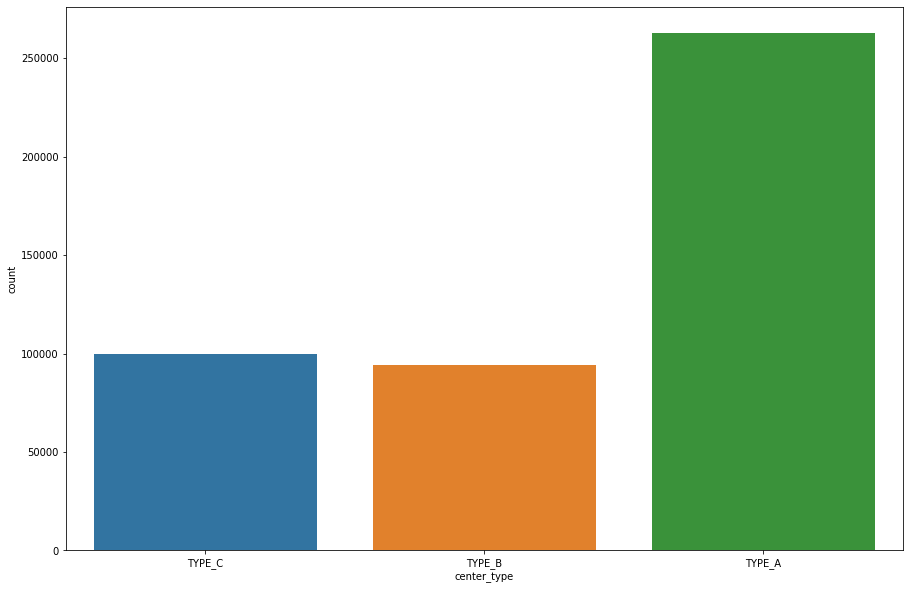

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x=train_data.center_type)

The distribution of center_type is unbalanced with more TYPE_A

(array([  3432.,  13595.,  17451.,  47732., 136159., 140250.,  50136.,
         13046.,   7015.,  27732.]),
 array([0.9 , 1.51, 2.12, 2.73, 3.34, 3.95, 4.56, 5.17, 5.78, 6.39, 7.  ]),
 <a list of 10 Patch objects>)

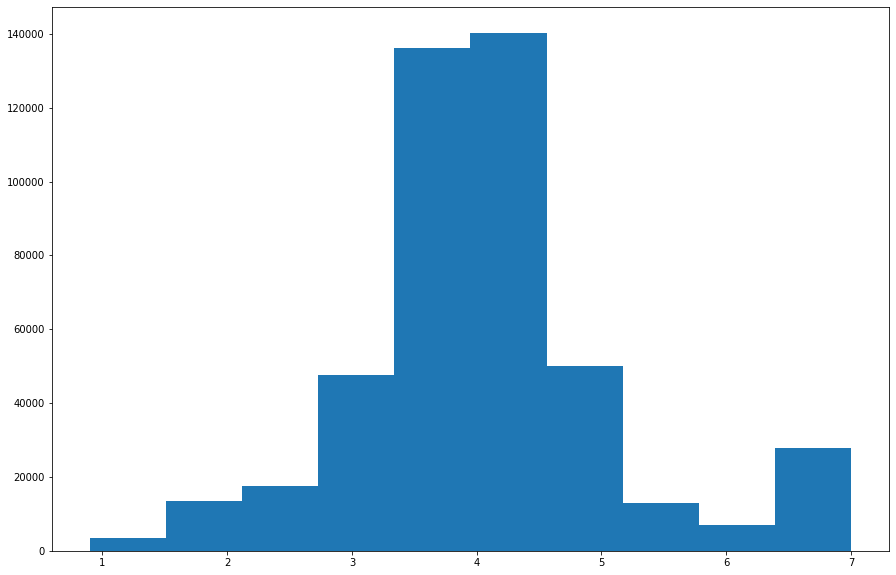

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
plt.hist(x=train_data.op_area)

op_area is roughly normally distributied.

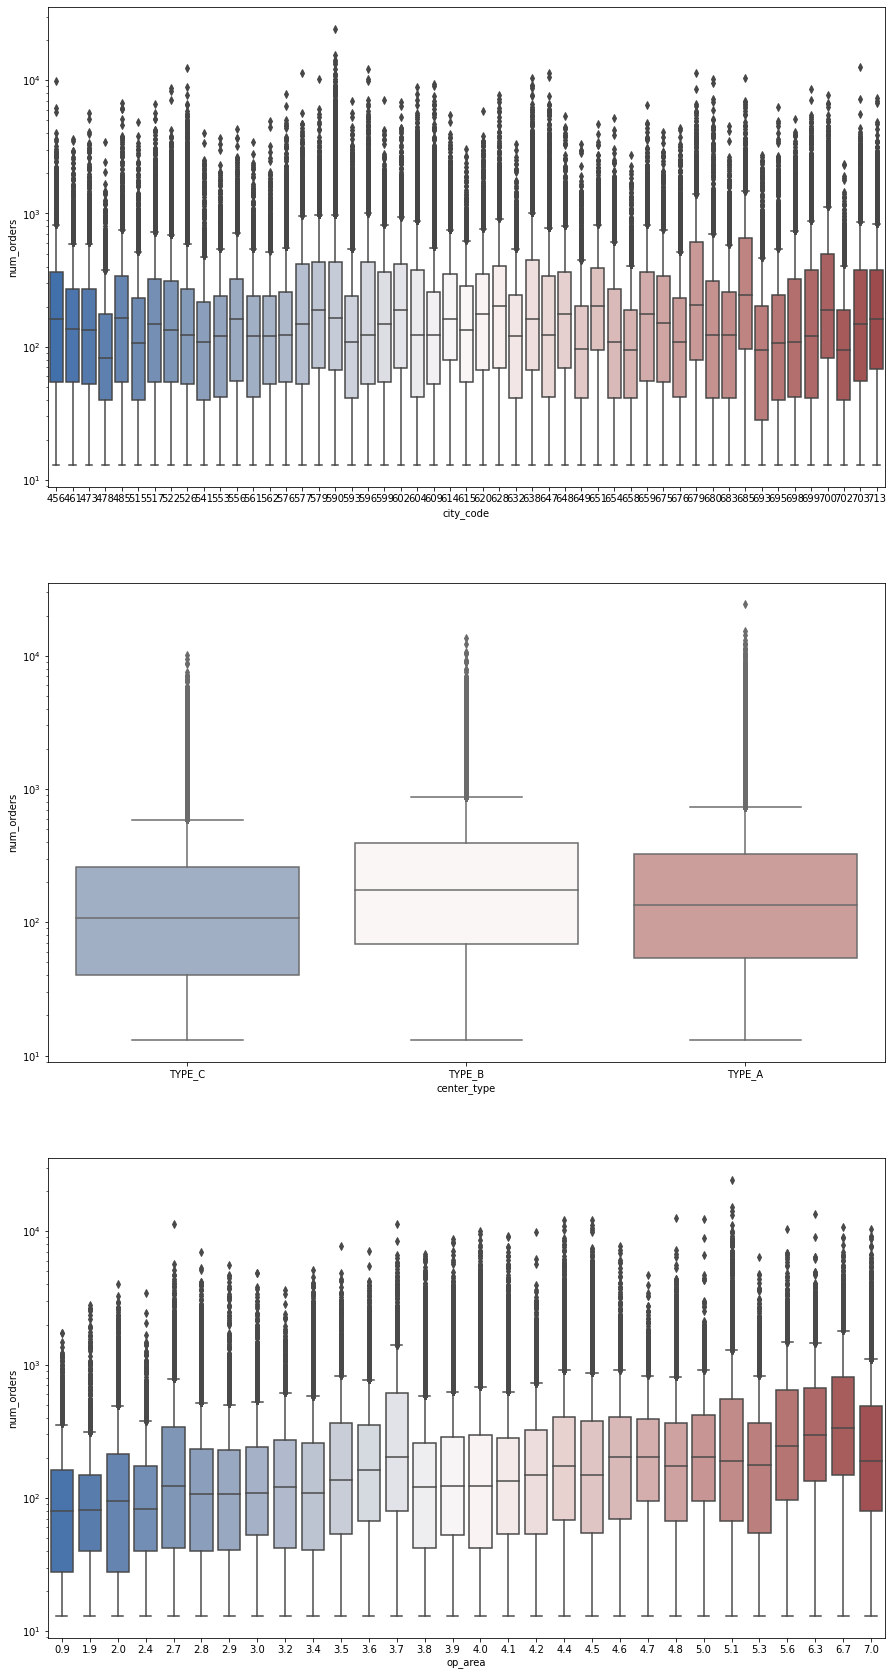

In [44]:
fig, ax = plt.subplots(3,1,figsize=(15,30))

for var, subplot in zip(['city_code','center_type','op_area'],ax.flatten()):
    subplot.set_yscale("log")
    sns.boxplot(x=var, y=target, data=train_data, palette="vlag", ax=subplot)

for city_code, center_type and op_area vs target (num_orders) distribution, the medians are around 100, but as we can see in the boxplot, there are many outliers for every category.

# Feature Engineering

Adding feature for difference between checkout and base price

In [45]:
df = train_data
df['price_diff'] = df.base_price - df.checkout_price

Relative difference between current price and historical average price

In [46]:
# Calculate Average price for all stores
df_mean_store = pd.DataFrame(df.groupby(['meal_id'])['checkout_price'].mean())
df_mean_store.columns = ['meal_price_avg']
df_mean_store.reset_index(inplace = True)

#combine with original df
df = pd.merge(df, df_mean_store, on=['meal_id'], how='left', suffixes=('', '_y'))
df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
df['delta_price_all_rel'] = (df['checkout_price'] - 
                                      df['meal_price_avg'])/df['meal_price_avg']

#dropping average meal price
df.drop(['meal_price_avg'], axis = 1, inplace = True)

## Introduce Lag

Introducing lags to the target variable sold

In [47]:
# Introduce lags (weeks)
lags = [1, 2, 3]
for lag in lags:
    df['orders_lag_'+str(lag)] = df.groupby(
        ['center_id', 'meal_id'], 
        as_index = False)['num_orders'].shift(lag).astype(np.float16)
    
    
for x in lags: 
    df['orders_lag_'+str(x)] = df['orders_lag_'+str(x)].fillna(df.groupby(['center_id', 'meal_id'])['orders_lag_'+str(x)].transform('mean'))

df.dropna(inplace = True)

## Rolling Average (Window) on Actual orders

In [48]:
# Average for the last n weeks
windows = [2,3,4]
for weeks in windows:
    df['rolling_orders_mean_{}'.format(weeks)] = df.groupby(
    ['center_id', 'meal_id'])['num_orders'].transform(
    lambda x: x.rolling(window=weeks, center=True).mean()).astype(np.float16)
    
    
    
for weeks in windows: 
    df['rolling_orders_mean_'+str(weeks)] = df['rolling_orders_mean_'+str(weeks)].fillna(df.groupby(['center_id', 'meal_id'])['rolling_orders_mean_'+str(weeks)].transform('mean'))

df.dropna(inplace = True)    
    

In [49]:
(df.isnull() == True).sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
price_diff               0
delta_price_all_rel      0
orders_lag_1             0
orders_lag_2             0
orders_lag_3             0
rolling_orders_mean_2    0
rolling_orders_mean_3    0
rolling_orders_mean_4    0
dtype: int64

## Trends

In [50]:
#average of meal_id num_orders 

df['avg_num_orders'] = df.groupby(
    ['meal_id'])['num_orders'].transform('mean').astype(np.float16)

df['diff_order_perc'] = (df['num_orders']-df['avg_num_orders'])/df['avg_num_orders']

## Additional Potential Feature Engineering? (Not Included)

- Was the store shut? For how many days? 
- Most amount of orders of a specific dish?
- Seasonality / once we get more info on datetime stuff
- Different for different stores? 
- Are products in same category getting cannabilised?

# Preprocessing

In [51]:
y = df['num_orders']
X = df.drop(columns = ['id', 'num_orders'])
X_dev, X_test, y_dev, y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [52]:
ohe_features = ['center_type','cuisine']
te_features = ['category']
num_features = ['week','center_id','meal_id','city_code','region_code',
                'op_area','checkout_price','base_price','emailer_for_promotion',
                'homepage_featured', 'price_diff', 'delta_price_all_rel', 
                'orders_lag_1', 'orders_lag_2', 'orders_lag_3', 'rolling_orders_mean_2', 
               'rolling_orders_mean_3', 'rolling_orders_mean_4', 'avg_num_orders', 'diff_order_perc' ]
preprocess = make_column_transformer((StandardScaler(),num_features),
                                    (OneHotEncoder(handle_unknown='ignore'), ohe_features),
                                    (TargetEncoder(handle_unknown='ignore'), te_features),
                                    remainder='passthrough')

In [53]:
X_dev

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,price_diff,delta_price_all_rel,orders_lag_1,orders_lag_2,orders_lag_3,rolling_orders_mean_2,rolling_orders_mean_3,rolling_orders_mean_4,avg_num_orders,diff_order_perc
406841,130,65,1247,447.23,446.23,0,0,Biryani,Indian,602,34,TYPE_A,4.8,-1.00,0.010304,42.0,53.0,14.0,28.5,28.328125,34.50,32.28125,-0.535334
74209,26,174,2322,383.15,384.15,0,0,Beverages,Continental,700,56,TYPE_A,7.0,1.00,0.095473,256.0,258.0,243.0,229.5,216.000000,226.50,208.87500,-0.028127
74986,26,23,1216,406.43,407.43,0,1,Pasta,Italian,698,23,TYPE_A,3.4,1.00,0.028068,53.0,27.0,67.0,33.0,26.671875,26.75,55.03125,-0.763771
139484,48,83,2569,326.89,327.89,0,0,Salad,Italian,659,77,TYPE_A,5.3,1.00,0.042740,324.0,296.0,310.0,385.5,392.000000,368.00,352.50000,0.268085
118402,41,74,2664,328.89,327.89,0,0,Salad,Italian,702,35,TYPE_A,2.8,-1.00,0.058747,378.0,432.0,257.0,385.0,364.250000,381.25,396.00000,-0.010101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259184,85,53,1109,250.26,309.43,0,0,Rice Bowl,Indian,590,56,TYPE_A,3.8,59.17,-0.068045,202.0,392.0,405.0,243.5,230.375000,270.75,572.00000,-0.501748
365848,118,36,2306,336.62,335.62,0,0,Pasta,Italian,517,56,TYPE_B,4.4,-1.00,0.151228,28.0,27.0,54.0,20.5,31.328125,30.25,61.09375,-0.787212
131938,45,104,1062,159.11,180.42,0,0,Beverages,Italian,647,56,TYPE_A,4.5,21.31,-0.071247,661.0,365.0,647.0,776.5,751.500000,655.00,423.25000,1.107501
146873,50,27,1216,408.43,407.43,0,0,Pasta,Italian,713,85,TYPE_A,4.5,-1.00,0.033127,69.0,41.0,55.0,54.5,58.656250,54.25,55.03125,-0.273140


# Deploying Model

## Random Forest

In [54]:
pipe = make_pipeline(preprocess, RandomForestRegressor(random_state=100,n_jobs = -1,verbose =1))
pipe.fit(X_dev, y_dev)
print(f'Test score:',pipe.score(X_test,y_test))
print(f'Dev score:',pipe.score(X_dev,y_dev))
s1 = pipe.score(X_test,y_test)




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.4s finished


Test score: 0.9974257500188936


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Dev score: 0.9993146529781501


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.4s finished


In [55]:
feature_names = df.columns
feature_importances = pipe.steps[1][1].feature_importances_

In [56]:
feat_imps = list(zip(feature_names, feature_importances))
print(feat_imps)

[('id', 0.0012745682364709166), ('week', 8.347106898900364e-05), ('center_id', 0.00026768726554943467), ('meal_id', 5.814826222307527e-05), ('checkout_price', 3.1760127171615694e-05), ('base_price', 5.797491396162555e-05), ('emailer_for_promotion', 0.00028035004947775144), ('homepage_featured', 0.00032570316348156677), ('num_orders', 2.554997995868551e-05), ('category', 2.069234726906248e-05), ('cuisine', 0.00024241219789682939), ('city_code', 0.00015950210135835861), ('region_code', 0.041129938282536346), ('center_type', 0.00017242860158393896), ('op_area', 0.00020460440808077552), ('price_diff', 0.7822321442103106), ('delta_price_all_rel', 0.03505082787616115), ('orders_lag_1', 0.001320066125012249), ('orders_lag_2', 0.018158365796029103), ('orders_lag_3', 0.11822194417529794), ('rolling_orders_mean_2', 1.6600871528724254e-05), ('rolling_orders_mean_3', 1.134445619191147e-05), ('rolling_orders_mean_4', 7.55895230555868e-06), ('avg_num_orders', 6.486006179096624e-06), ('diff_order_per

In [58]:
feat_imps.sort(key=lambda tup: tup[1], reverse = True)
feat_imp_df= pd.DataFrame(feat_imps)
feat_imp_df

,0,1
0,price_diff,0.782232
1,orders_lag_3,0.118222
2,region_code,0.041130
3,delta_price_all_rel,0.035051
4,orders_lag_2,0.018158
5,orders_lag_1,0.001320
6,id,0.001275
7,homepage_featured,0.000326
8,emailer_for_promotion,0.000280
9,center_id,0.000268


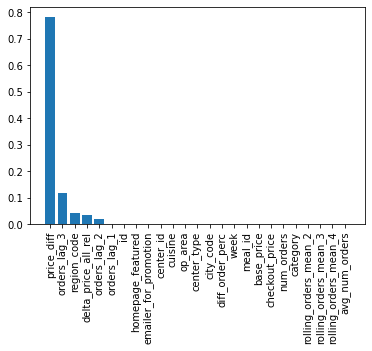

In [59]:
plt.xticks(rotation='vertical')
plt.bar(x=feat_imp_df[0],height=feat_imp_df[1])
plt.show()